In [22]:
import sys
sys.path.insert(0, '/Users/kedzie/Documents/Berkeley/notebooks/utilities')

import pdb
import pandas as pd
import numpy as np
# import scipy
# from scipy.optimize import curve_fit
from matplotlib import rcParams as rc
rc['mathtext.default'] = 'regular'
import matplotlib.pyplot as plt
from collections.abc import Iterable
from utility_functions.utils import *
import os
import re 
def read_dems(file):
    df = pd.read_csv(file, sep ='\t')
    df = df.rename(columns=lambda x: x.replace('.00000', ''))
    df.rename(columns={'0':'time/min', '0.1':'temperature/C', '0.2': 'pressure/torr', '0.3':'current/mA', '0.4':'voltage/V'}, inplace= True)
    #normalize time function
    df['time/min'] = df['time/min']-df['time/min'].iloc[0]
    
    return df
def find_charge(fold):
    files = os.listdir(fold)
    regex = 'chrg'
    look='mpt'
    #find the file names that have 'chrg' in the name and then find only the ones of those that are .mpt files
    all_chrg= [fold + f for f in files if re.search(regex, f)]
    chrg_ec = [ i for i in all_chrg if re.search(look, i)]
    chrg_ec.sort()

    #read in the mpts as dataframes and put in list ls
    ls=[]
    for i in range(len(chrg_ec)):
        ls.append(read_data(chrg_ec[i]))
        
    #normalize all the dataframes by time zero in first dataframe
    for i in range(len(ls)):
        ls[i]['time/s']= ls[i]['time/s']-ls[0]['time/s'].iloc[0]
    
    return(ls)

In [23]:


def convert_ion_current(demsdata):
    #slopes and intercepts in an array [oxygen, co2, hydrogen, ethylene, carbon monoxide]
    m = [1.144462577, 1.041140556, 0.06148247455, 1.690955209, 0.7959230955]
    m = [1.4, 1.2, 0.06148247455, 1.690955209, 0.7959230955]
    #new as of 
    #m = [1.463047028, 1.255655142, 0.06148247455*1.2, 1.690955209, 0.7959230955]
    #m = [1.1513186, 1.01161546, 0.06148247455, 1.690955209, 0.7959230955]
    
    #inf_ar = 278.6590323 * demsdata['36']
    inf_ar = 288.7462016 * demsdata['36']   #as of 2/2019
    
    names= ['2','26','28','32','34','36','44','45']
    vol = 499 #uL *10^-6 
    R = 62.363577 #  L*torr / (K*mol)
    
    #covert all pressures into umoles
    demsdata['2'] = (m[2] * demsdata['2']/inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['26'] = (m[3] * demsdata['26'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['28'] = (m[4] * demsdata['28'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)    
    demsdata['32'] = (m[0] * demsdata['32'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['34'] = (m[0] * demsdata['34'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    #demsdata['36'] = (m[0] * demsdata['36'] *10**-9/inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['44'] = (m[1] * demsdata['44'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)
    demsdata['45'] = (m[1] * demsdata['45'] /inf_ar ) * demsdata['pressure/torr']*vol/R/ (demsdata['temperature/C']+273)

    return (demsdata) 
def baselinecorr(data, mz, baseline1, baseline2):
    #data is the DEMS mass spec dataframe, mz is the mass spec number you're interested in, ...
    # end1 is the end of initial ocv (in s), start2 is the start of baseline ocv after cycling (min)
    #find where the ocv ends by comparing eclab times with labview times
    index = getnearpos(data['time/min'], baseline1+40)
    index2 = getnearpos(data['time/min'], baseline2+40)
    
    plt.figure()
    plt.plot(data['time/min'], data[str(mz)], 'o-', label=str(mz))
    
    def slope(fullfile, mz, time1, time2):
        m=(fullfile[str(mz)].iloc[time2]-fullfile[str(mz)].iloc[time1])/(fullfile['time/min'].iloc[time2]-fullfile['time/min'].iloc[time1])
        return m
    
    m= slope( data, mz, index+1, index2 )
    correct=(m)*(data['time/min']- data['time/min'].iloc[index]) + data[str(mz)].iloc[index]

    plt.plot(data['time/min'], correct, '.', label='baseline')
    data[str(mz)] = data[str(mz)]-correct
    
    plt.plot(data['time/min'], data[str(mz)], '-.', label='corrected data')
    plt.xlim(25,450)
    plt.ylim(0,0.2)
    if (mz==32):
        plt.ylim(0,2)
    plt.xlabel('time (min)')
    plt.ylabel('mass spec signal')
    plt.legend()                            
    
    return (data)

In [48]:
def plot_dems2(chrg_ec, demi, r, ethylene='None', n=1 , percent='None'):
    #oxyi= baselinecorr( demi, 36, chrg_ec[0]['time/s'].iloc[-1], time_min)
    base1= chrg_ec[4]['time/s'].iloc[0]/60
    base2= chrg_ec[4]['time/s'].iloc[-1]/60
    umolesdf = convert_ion_current(demi) 
    
    #umolesdf.to_csv('/Users/kedzie/Desktop/190413_na_graphite_MCMB_CA_dems_convertedcurrent.csv')
    
    oxy = baselinecorr( demi, 32, base1, base2)
    hydro = baselinecorr( oxy, 2, base1, base2)
    co2 = baselinecorr( hydro, 44, base1, base2)
    #c2h4 = baselinecorr( co2, 26, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #co = baselinecorr( c2h4, 28, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    
    #pdb.set_trace()
    #convert ion current to moles of gas for baseline corrected data
    umolesdf = co2
    total_umoles= umolesdf['2']+umolesdf['32']+umolesdf['44']
    timediff= np.mean(np.gradient(umolesdf['time/min']))

    
    chrg_ec[2]['Capacity/mA.h'] += chrg_ec[1]['Capacity/mA.h'].iloc[-1]
    if n==1:
        chrg_ec[3]['Capacity/mA.h'] += chrg_ec[2]['Capacity/mA.h'].iloc[-1]
    print(chrg_ec[3]['Capacity/mA.h'].iloc[-1])    
    charge_i= np.mean(chrg_ec[1]['I/mA'])  #normalize charge current by surface area (mA/cm2)
    charge_start= chrg_ec[1]['time/s'].iloc[0]/60 #find the start time for charge in eclab
    cap=[]
    curr=[]
    if n==1:
        new=pd.concat([chrg_ec[1], chrg_ec[2], chrg_ec[3]], sort=True)
    else:
        new=pd.concat([chrg_ec[1], chrg_ec[2]], sort=True)
        
    for j in range( len(umolesdf)):  
        
        index=getnearpos( new['time/s'], (umolesdf['time/min'].iloc[j]*60))
        #index=np.argmin(np.abs(new['time/s']-umolesdf['time/min'].iloc[j]*60).values)
        
        cap.append( new['Capacity/mA.h'].iloc[index])
        curr.append( new['I/mA'].iloc[index])
        #print( str(new['time/s'].iloc[index]/60) + ' and '+ str(umolesdf['time/min'].iloc[j]) )

    umolesdf['Capacity/mAh']= cap
    umolesdf['I/mA']=curr
    
    
    x= [0.0, chrg_ec[2]['Capacity/mA.h'].iloc[-1]]
    y= [3.6*charge_i/60/(n*96485)*10**6, 3.6*charge_i/(n*96485*60)*10**6]
    
    fig,ax = plt.subplots(figsize= (7,5), facecolor='None')
    ax2=ax.twinx()
    start_charge= getnearpos(umolesdf['time/min'], chrg_ec[0]['time/s'].iloc[-1]/60)
    end_charge=getnearpos(umolesdf['time/min'], chrg_ec[3]['time/s'].iloc[-1]/60)+3
    umoles_32 = np.cumsum(umolesdf['32']).iloc[end_charge] - np.cumsum(umolesdf['32']).iloc[start_charge]
    umoles_2 = np.cumsum(umolesdf['2']).iloc[end_charge] - np.cumsum(umolesdf['2']).iloc[start_charge]
    umoles_44 = np.cumsum(umolesdf['44']).iloc[-1] - np.cumsum(umolesdf['44']).iloc[5]
    print (umoles_32, umoles_2, umoles_44)
    factor=1
    
    if percent=='on':
        ax2.plot(umolesdf['Capacity/mAh'][6:90] , (umolesdf['32']/total_umoles*100)[7:91] , 'o:', markersize=4, label='O$_2$', color='#2da322')
        ax2.plot(umolesdf['Capacity/mAh'][6:90], (umolesdf['2']/total_umoles*100)[7:91] , 'o:', markersize=4, label= 'H$_2$', color='#CC6600')
        ax2.plot(umolesdf['Capacity/mAh'][6:90], (umolesdf['44']/total_umoles*100)[7:91] , 'o:', markersize=4, label= 'CO$_2$', color='xkcd:maroon', alpha=0.9)
        ax2.set_ylabel('% of Gas Evolved', fontsize=20)

    else:
        ax2.plot(umolesdf['Capacity/mAh'][6:120] , 3.6*umolesdf['I/mA'][6:120]/(n*96485*60)*10**6 , 'ko:', markersize=4, label= str(n)+ 'e$^-$ / O$_2$')
        ax2.plot(umolesdf['Capacity/mAh'][3:119], (umolesdf['32']/timediff/factor)[4:120] , 'o:', markersize=4, label='O$_2$', color='#2da322')
        ax2.plot(umolesdf['Capacity/mAh'][4:120], (umolesdf['2']/timediff)[4:120] , 'o:', markersize=4, label= 'H$_2$', color='#006669')
        ax2.plot(umolesdf['Capacity/mAh'][4:120], (umolesdf['44']/timediff)[4:120] , 'o:', markersize=4, label = 'CO$_2$', color='#ffa600')
        ax2.set_ylabel('Gas Evolution ($\mu$mol / min)', fontsize=20)
        
    #ax2.plot(umolesdf['Capacity/mAh'][:60], (umolesdf['36']/timediff/factor)[:60] , 'o:', markersize=4, label = '36')
    
    #ax.plot(x,y, 'k--', label= str(n)+ 'e$^-$ / O$_2$')

    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='y', which='major', labelsize=15)

    ax2.legend( loc='upper right')
    
    ax.plot(chrg_ec[1]['Capacity/mA.h'], chrg_ec[1]['Ewe/V'],'k', linewidth=2)
    ax.plot(chrg_ec[2]['Capacity/mA.h'], chrg_ec[2]['Ewe/V'],'k', linewidth=2)
    if n==1:
        ax.plot(chrg_ec[3]['Capacity/mA.h'], chrg_ec[3]['Ewe/V'],'k', linewidth=2)
    #034054 (previous color)

#     for i in range (1,len(chrg_ec)):
#         ax2.plot(chrg_ec[i]['Capacity/mA.h'], chrg_ec[i]['Ewe/V'],'m')
    ax.set_xlabel('Capacity (mAh)', fontsize=20)
    ax.set_ylabel('Potential (V vs. Na/Na$^+$)', fontsize=20)
    ax.set_ylim([1.6,4.0])
    #plt.xticks(np.arange(0, 1.05, step=0.1))
    if n==1:
        epermol= chrg_ec[3]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)
    else:
        epermol= chrg_ec[2]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)

    #theor_o2 = disch_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485
    
    print('umoles O2: '+ str(umoles_32))   
    print('e per mol: ' + str(epermol))
    #plt.title("Cycle " + str(r))
    return



-39.267863985276804
0.8780280003945033
31.191068095064427 -0.1279950630342124 -0.0467705347757445
umoles O2: 31.191068095064427
e per mol: 1.050318024750226
1.144123739666409
2.7947408995099274 -0.016524603420030648 -0.011511519316639855
umoles O2: 2.7947408995099274
e per mol: 15.274751230445103


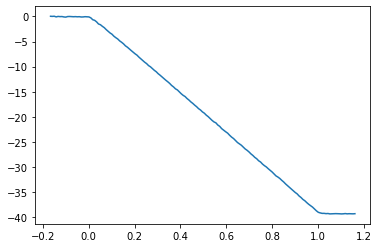

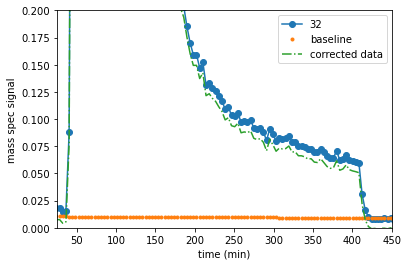

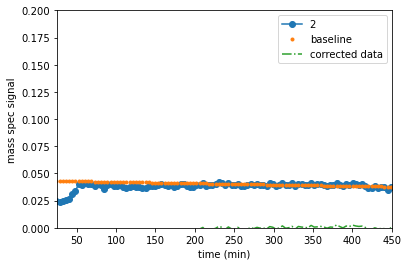

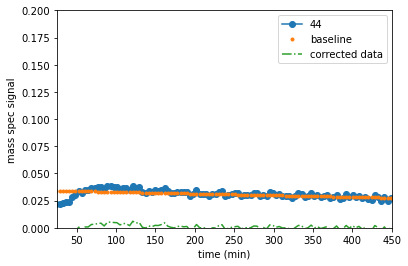

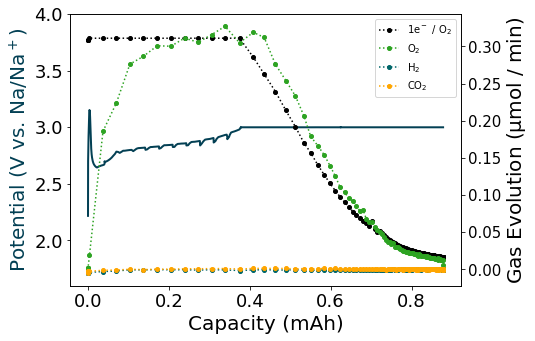

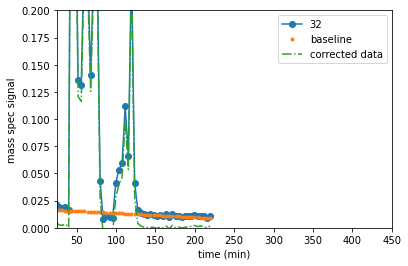

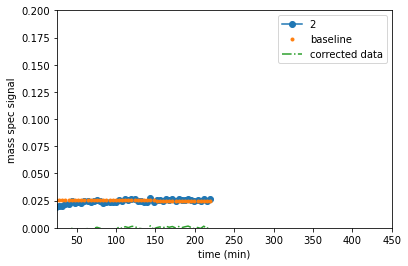

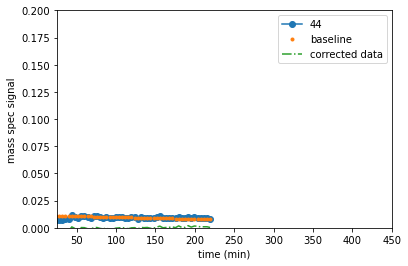

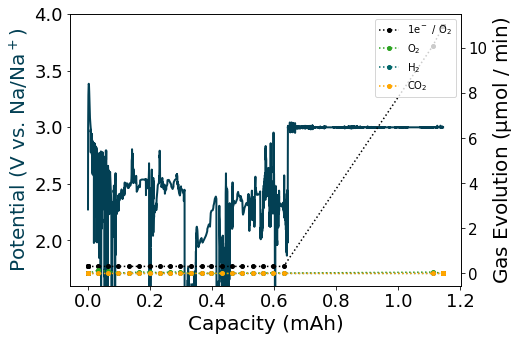

In [9]:
disch= read_press('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200205_Na_10%ptfeMCMB_CA_cell1_dems/200205_Na_10%ptfeMCMB_CA_cell1_dems/200205_demscell_MCMB_CA_disch1/200205_demscell_MCMB_CA_disch1_Ch1__2020-02-05_13.55_58.txt')
temp = disch['temperature/C']+273
umoles = disch['pressure/torr']/760*headspace(1)/temp/0.082057
umoles = umoles-umoles.iloc[10]


plt.figure()
plt.plot((disch['time/s']-20*60)/60/60*0.5, umoles)
print(umoles.iloc[-1] - umoles.iloc[15])

cy1_2= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200205_Na_10%ptfeMCMB_CA_cell1_dems/200205_Na_10%ptfeMCMB_CA_cell2_dems/200205_Na_10%ptfeMCMB_CA_cell2_dems_chrg_cycle1_2020-02-05_17.20_04_ch2.txt')
cell2_folder= find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200205_Na_10%ptfeMCMB_CA_cell1_dems/200205_Na_10%ptfeMCMB_CA_cell2_dems/')
#plot_dems2(cell2_folder, cy1_2, 2, n=1)

#cy2_fold =[cell2_folder[5], cell2_folder[6], cell2_folder[7], cell2_folder[8], cell2_folder[9]]
#plot_dems2(cy2_fold, cy1_2, 2, n=1)




cy1_1 = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200205_Na_10%ptfeMCMB_CA_cell1_dems/200205_Na_10%ptfeMCMB_CA_cell1_dems/200205_Na_10%ptfeMCMB_CA_cell1_dems_chrg_cycle1_2020-02-05_17.20_04_ch1.txt')
cell1_folder = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200205_Na_10%ptfeMCMB_CA_cell1_dems/200205_Na_10%ptfeMCMB_CA_cell1_dems/')
plot_dems2(cell1_folder, cy1_1, 1, n=1)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200205_Na_10%ptfeMCMB_CA_cell1_dems/200205_Na_10%ptfeMCMB_CA_cell1_dems/CA_DEMS_cycle1_cell1.png', transparent = True, dpi=600, bbox_inches='tight')



cy2_1= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200205_Na_10%ptfeMCMB_CA_cell1_dems/200205_Na_10%ptfeMCMB_CA_cell1_dems/200205_Na_10%ptfeMCMB_CA_cell1_dems_cycle2_chrg_2020-02-06_12.27_32.txt')
fc2_cy2 = [cell1_folder[5], cell1_folder[6], cell1_folder[7], cell1_folder[8], cell1_folder[9]]
plot_dems2(fc2_cy2, cy2_1, 2, n=1)



In [40]:
def plot_dems(chrg_ec, demi, r, ethylene='None', n=2 ):
    base1= chrg_ec[2]['time/s'].iloc[0]/60
    base2= chrg_ec[2]['time/s'].iloc[-1]/60
    umolesdf = convert_ion_current(demi) 
    
    oxy = baselinecorr( demi, 32, base1, base2)
    hydro = baselinecorr( oxy, 2, base1, base2)
    co2 = baselinecorr( hydro, 44, base1, base2)
    #c2h4 = baselinecorr( co2, 26, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    #co = baselinecorr( c2h4, 28, chrg_ec[0]['time/s'].iloc[-1], end_ocv)
    umolesdf=co2
    
    #convert ion current to moles of gas for baseline corrected data
    timediff= np.mean(np.gradient(umolesdf['time/min']))
    charge_i= np.mean(chrg_ec[1]['I/mA'])
    
    charge_start= chrg_ec[1]['time/s'].iloc[0]/60 #find the start time for charge in eclab
      
    cap=[]
    curr=[]
    new= chrg_ec[1]
        
    for j in range(len(umolesdf)):  
        index=getnearpos( chrg_ec[1]['time/s'], (umolesdf['time/min'].iloc[j]*60))
        #index=np.argmin(np.abs(new['time/s']-umolesdf['time/min'].iloc[j]*60).values)
        cap.append( new['Capacity/mA.h'].iloc[index])
        curr.append( new['I/mA'].iloc[index])

    umolesdf['Capacity/mAh']= cap
    umolesdf['I/mA']=curr
    
    x= [0.0, chrg_ec[1]['Capacity/mA.h'].iloc[-1]]
    y= [3.6*charge_i/60/(n*96485)*10**6, 3.6*charge_i/(n*96485*60)*10**6]
    
    fig,ax = plt.subplots(figsize= (8,5), facecolor='None')
    ax2=ax.twinx()
    start_charge= getnearpos(umolesdf['time/min'], chrg_ec[0]['time/s'].iloc[-1]/60)
    end_charge=getnearpos(umolesdf['time/min'], chrg_ec[1]['time/s'].iloc[-1]/60)+3
    umoles_32 = np.cumsum(umolesdf['32']).iloc[end_charge] - np.cumsum(umolesdf['32']).iloc[start_charge]
    umoles_2 = np.cumsum(umolesdf['2']).iloc[-1] - np.cumsum(umolesdf['2']).iloc[start_charge]
    umoles_44 = np.cumsum(umolesdf['44']).iloc[-1] - np.cumsum(umolesdf['44']).iloc[start_charge]

    print ('o2: '+ str(umoles_32), 'h2: ' + str(umoles_2), 'co2: '+ str(umoles_44))
    factor=1
    if n==2:
        factor=1
    j1= 5
    j2=50
    ax2.plot(umolesdf['Capacity/mAh'][6:50] , 3.6*umolesdf['I/mA'][6:50]/(n*96485*60)*10**6 , 'ko:', markersize=4, label= str(n)+ 'e$^-$ / O$_2$')
    ax2.plot(umolesdf['Capacity/mAh'][5:60], (umolesdf['32']/timediff/factor)[5:60] , 'o:',  alpha=1, markersize=5, label='O$_2$', color='#2da322')   
    ax2.plot(umolesdf['Capacity/mAh'][5:60], (umolesdf['2']/timediff/factor)[5:60] , 'o:', markersize=5, label= 'H$_2$', color='#006669')
   # ax2.plot(umolesdf['Capacity/mAh'][:100], (umolesdf['28']/timediff/factor)[:100] , 'o:', alpha=0 , markersize=4, label = '28')
    ax2.plot(umolesdf['Capacity/mAh'][j1:j2], (umolesdf['44']/timediff/factor)[j1:j2] , 'o:', markersize=5, label = 'CO$_2$', color = '#ff8100')
    #ax2.plot(umolesdf['Capacity/mAh'][:60], (umolesdf['36']/timediff/factor)[:60] , 'o:', markersize=4, label = '36')
    
    #ax.plot(x,y, 'k--', label= str(n)+ 'e$^-$ / O$_2$')
    
    #ax2.legend(loc='upper center', bbox_to_anchor=[0.85, 0.85], fontsize=16) #, title= 'm/z value')
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.17), ncol=4, fancybox=True, shadow=True, fontsize=16)
    ax.plot(chrg_ec[1]['Capacity/mA.h'], chrg_ec[1]['Ewe/V'],'k')
    #034054 (previous color)
    ax.set_ylim([1.6,4.8])
    rc['font.size'] = 12
#     for i in range (1,len(chrg_ec)):
#         ax2.plot(chrg_ec[i]['Capacity/mA.h'], chrg_ec[i]['Ewe/V'],'m')
    ax.set_xlabel('Capacity (mAh)', fontsize=20)
    ax.set_ylabel('Potential (V vs. Na/Na$^+$)', color='k', fontsize=20)
    ax2.set_ylabel('Gas Evolution ($\mu$mol / min)', fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax2.tick_params(axis='y', which='major', labelsize=15)
    
    


    #plt.xticks(np.arange(0, 1.05, step=0.1))
    epermol= chrg_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)


    #     if n==1:
#         epermol= chrg_ec[3]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)
#     else:
#         epermol= chrg_ec[2]['Capacity/mA.h'].iloc[-1]*3.6/96485/(umoles_32/factor)*10**(6)

    #theor_o2 = disch_ec[1]['Capacity/mA.h'].iloc[-1]*3.6/96485
    
    print('umoles O2: '+ str(umoles_32))   
    print('e per mol: ' + str(epermol))
    
    return

Text(0, 0.5, 'V')

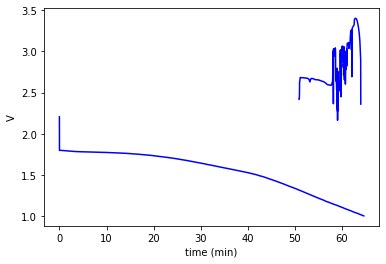

In [10]:
CP_chrg= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200205_Na_10%ptfeMCMB_CA_cell1_dems/200206_Na_10%ptfeMCMB_CP_cell1_dems/200206_Na_10%ptfeMCMB_CP_cell1_dems_chrg_cycle1_2020-02-06_20.06_55.txt')
CP_fold = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200205_Na_10%ptfeMCMB_CA_cell1_dems/200206_Na_10%ptfeMCMB_CP_cell1_dems/')
overallfolder= folder_files('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200205_Na_10%ptfeMCMB_CA_cell1_dems/200206_Na_10%ptfeMCMB_CP_cell1_dems/')
#plot_dems(CP_fold, CP_chrg, 1, n=1)

#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200205_Na_10%ptfeMCMB_CA_cell1_dems/200206_Na_10%ptfeMCMB_CP_cell1_dems/CP_DEMS_cycle1.png', transparent = True, dpi=600, bbox_inches='tight')
CP_chrg2=read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200205_Na_10%ptfeMCMB_CA_cell1_dems/200206_Na_10%ptfeMCMB_CP_cell1_dems/200206_Na_10%ptfeMCMB_CP_cell1_dems_cycle2_chrg_2020-02-07_13.21_30.txt')

plt.figure()
plt.plot(overallfolder[10]['time/s']/60-20, overallfolder[10]['Ewe/V'],  'b')
plt.plot(94- CP_fold[4]['time/s']/60, CP_fold[4]['Ewe/V'],  'b')
plt.xlabel('time (min)')
plt.ylabel('V')

#plot_dems(fold_cy2, CP_chrg2, 2, n=1)



0.8238298363155788
28.11646409065997 0.02458157114866548 -0.3299430059852749
umoles O2: 28.11646409065997
e per mol: 1.0932500678907149


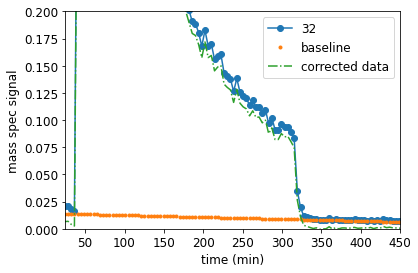

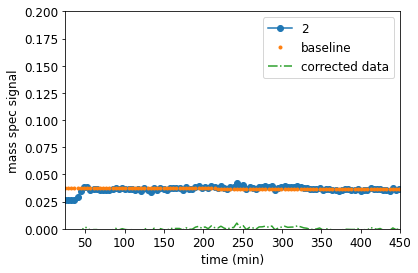

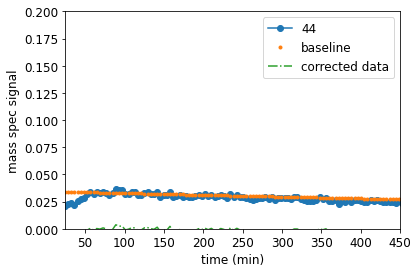

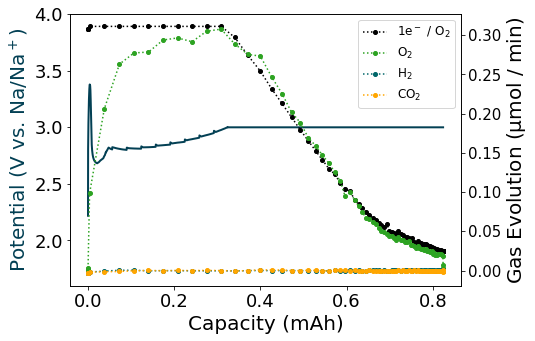

In [17]:
CA_cell1= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200205_Na_10%ptfeMCMB_CA_cell1_dems/200205_Na_10%ptfeMCMB_CA_cell2_dems/200205_Na_10%ptfeMCMB_CA_cell2_dems_chrg_cycle1_2020-02-05_17.20_04_ch2.txt')
CA_fold1=find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200205_Na_10%ptfeMCMB_CA_cell1_dems/200205_Na_10%ptfeMCMB_CA_cell2_dems/')
plot_dems2(CA_fold1, CA_cell1, 2, n=1)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200205_Na_10%ptfeMCMB_CA_cell1_dems/200205_Na_10%ptfeMCMB_CA_cell2_dems/CA_DEMS_cycle1.png', transparent = True, dpi=600, bbox_inches='tight')



In [16]:
cp1= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200217_Na_CP_MCMB10%PTFE_cycling_cell1_dems/200217_Na_CP_MCMB10%PTFE_cycling_cell1_chrg_rd2_2020-02-17_15.32_26_ch1.txt')
cpfold= find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2020/')
plot_dems(cpfold, cp1, 1, n=1)

cp2= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200217_Na_CP_MCMB10%PTFE_cycling_cell1_dems/200217_Na_CP_MCMB10%PTFE_cycling_dems_cell1_chrg_cycle2_2020-02-18_07.44_57_ch1.txt')
cpfold2= [cpfold[3], cpfold[4], cpfold[5]]
plot_dems(cpfold2, cp2, 1, n=1)
#plt.savefig('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200217_Na_CP_MCMB10%PTFE_cycling_cell1_dems/200217_CP_DEMS_cycle1.png', transparent = True, dpi=600, bbox_inches='tight')




IndexError: list index out of range

o2: 26.680318824912447 h2: 0.3222553721007353 co2: 0.41208612050949256
umoles O2: 26.680318824912447
e per mol: 1.3993753745013031


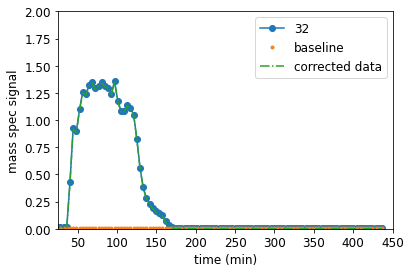

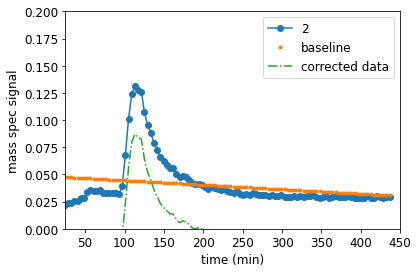

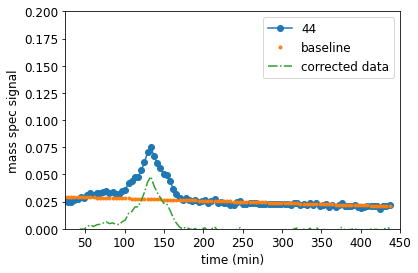

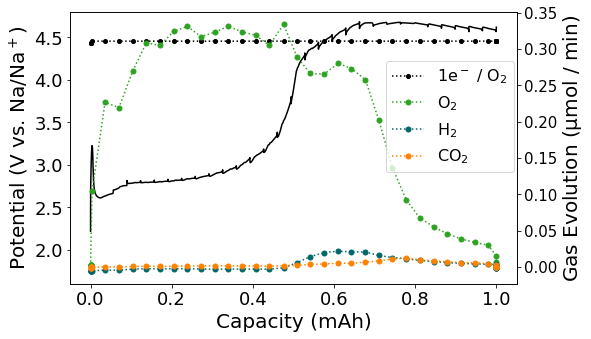

In [36]:
cp_cell2= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200217_Na_CP_MCMB10%PTFE_cycling_cell2_dems/200217_Na_CP_MCMB10%PTFE_cycling_cell2_chrg_rd2_2020-02-17_15.32_26_ch2.txt')
cpfold= find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200217_Na_CP_MCMB10%PTFE_cycling_cell2_dems/')
plot_dems(cpfold, cp_cell2, 1, n=1)
#plt.savefig('/Users/kedzie/Desktop/graphite CP DEMS.png', transparent = True, dpi=600, bbox_inches='tight')





o2: 36.795615080922914 h2: 0.2221393745826126 co2: 0.6829379708816181
umoles O2: 36.795615080922914
e per mol: 1.0141955107525422
0.8414361543125577
29.59215705193798 0.05439474924430923 0.39060229128951895
umoles O2: 29.59215705193798
e per mol: 1.0609312575849246


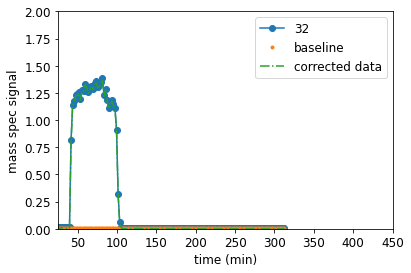

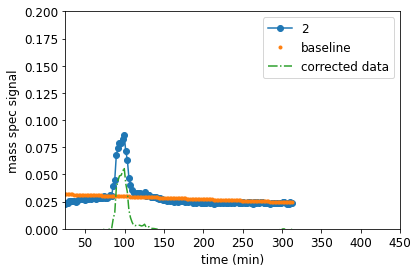

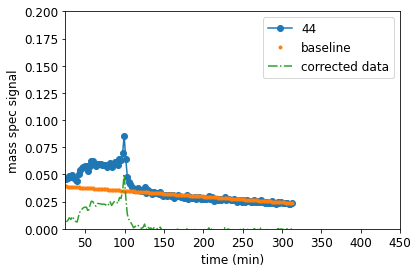

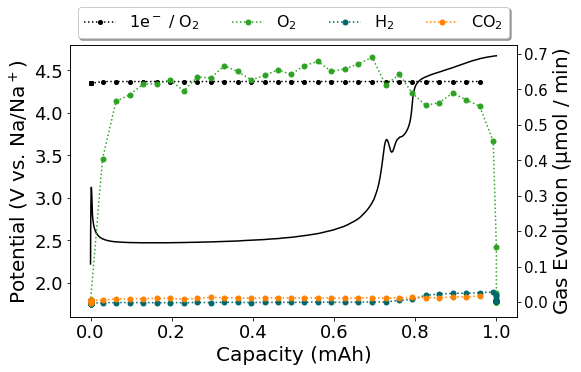

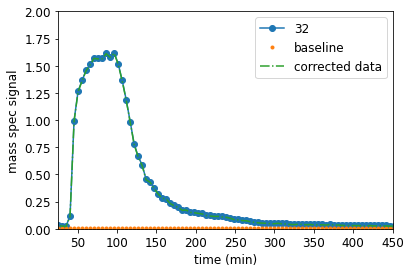

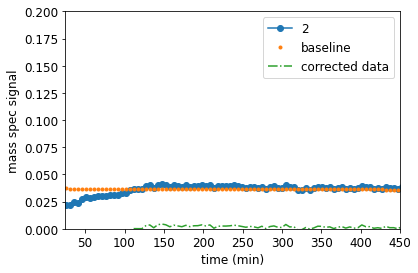

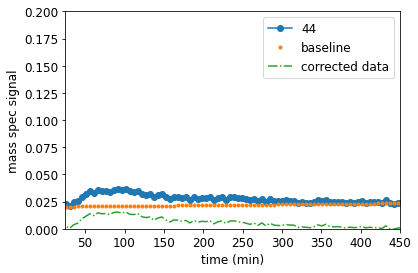

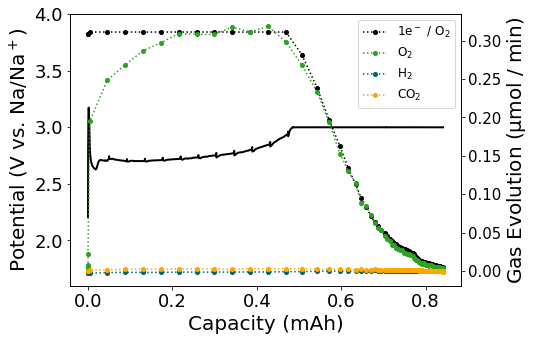

In [49]:
p50_cp= read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190127_Na_CP_2cycles_dems/190127_Na_CP_2cycles_dems_chrg_cycle1_2019-01-27_15.41_43.txt')
p50cpfold= find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2019/190127_Na_CP_2cycles_dems/')
plot_dems(p50cpfold, p50_cp, 1, n=1)

#plt.savefig('/Users/kedzie/Desktop/p50 CP DEMS.png', transparent = True, dpi=600, bbox_inches='tight')


mcmb = read_dems('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200706_Na_MCMB031220_CA_cell1_dems/200706_Na_MCMB031220_CA_cell1_dems_chrg_cy1_2020-07-06_15.08_57_ch1.txt')
mcmbfold = find_charge('/Users/kedzie/Documents/Berkeley/Research/Data/2020/200706_Na_MCMB031220_CA_cell1_dems/')
plot_dems2(mcmbfold, mcmb, 1, n=1)

